In [1]:
#!pip install pingouin

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, shapiro, spearmanr, kendalltau
from statsmodels.stats.stattools import jarque_bera 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.compat import lzip

import pingouin as pg



## Reproduction of Determinants of apartment prices in Warsaw by Xinyue Fang

Study made by Xinyue is focused on explaining how different determinants are affecting house price on micro level. Research focuses on factors that influence the price of apartments in Warsaw, following hypothesis are formulated:
1. Influence of apartment type on it's price, it is assumed that tenement apartments should be the cheapest.
2. Non-linear relationship between size and price, it is expected for price to rise rapidly with the increase of flat size.
3. Positive relationship between floor and price - the higher the apartment is situated the higher the price. Lowest floor flats should be the cheapest.
4. Negative relationship between distance from city center and price.
5. Positive relationship between number of ammenities and price.
6. Ownership relationship between type of ownership an price.
7. Positive relationship between existance of elavator and price.
8. Positive rlationship between existance of balcony and price.


## Methods helpful in further steps ##

Method transform_data_from_file() for transforming data to the form used in paper, and aggregate_data() for creating new dataset from additional source files from kaggle.

Methods for plotting histograms and box plots:

In [2]:
def plot_historgram(df: pd.DataFrame, column: str, xlabel: str, title: str):
    x = df[column].dropna()
    plt.hist(x, bins=20, color='blue', density=True)
    xfit = np.linspace(x.min(), x.max(), 1000)
    yfit = norm.pdf(xfit, loc=x.mean(), scale=x.std())
    plt.plot(xfit, yfit, 'r', linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)

In [3]:
def plot_boxplot(df: pd.DataFrame, column: str):
    y = df[column].dropna()
    sns.boxplot(y)
    plt.title("Boxplot")
    plt.ylabel(column)
    plt.show()

## Handling Data ##

Original dataset was taken from https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland . Originally research was done based on data from November 2023. Given the abilities of python which we are going to use, we decided to create two separate datasets - one just to reproduce the research and extend one with data since November 2023 up until June 2024. Source dataset from kaggle includes more variables than is required for research and rows for cities which are als not included, so we will need to do some adjusting of datasets.
Way to proceed:
1. Download data from aforementioned source and add csv files into source into data/source directory.
2. Recreate original dataset for November 2023 using transform_data_from_file() and create_dummy_variables() methods and drop id column.
3. Use methods aggregate aggregate_data() and create_dummy_variables() to generate extended dataset.

* We generated the data according to the paper, but there is no R codes for it, author prepared the data with Excel and didn't provide any information about it. That's why the original data generated by us is different from the real original data usded by author. So here our data description and visualization are based on the original data we generated, but the regression and problems with data part we used the original data prepared by author.

In [4]:
Apartment = pd.read_excel('Apartment.xlsx')

In [5]:
Apartment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            2692 non-null   int64  
 1   squareMeters    2692 non-null   float64
 2   FloorType       2692 non-null   int64  
 3   centreDistance  2692 non-null   float64
 4   poiCount        2692 non-null   int64  
 5   ownership       2692 non-null   int64  
 6   hasBalcony      2692 non-null   int64  
 7   hasElevator     2692 non-null   int64  
 8   price           2692 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 189.4 KB


## Data description and visualization ##

Here we are focusing on recreating original research - visualizing data and checking if it's similar to what has been discovered previously. Additionally, for each variable we are running tests for extended dataset.

# Price - reproduction

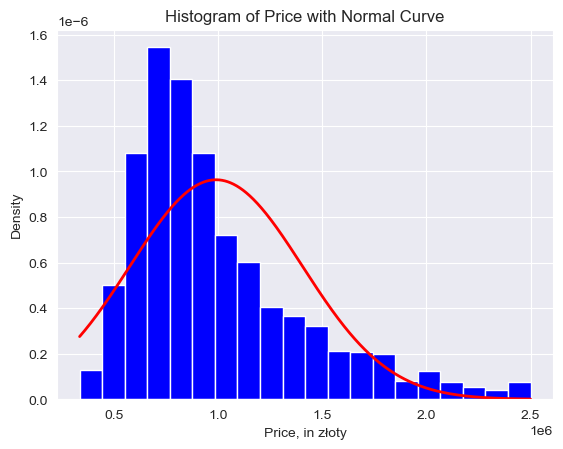

In [6]:
plot_historgram(Apartment, 'price', 'Price, in złoty', 'Histogram of Price with Normal Curve')

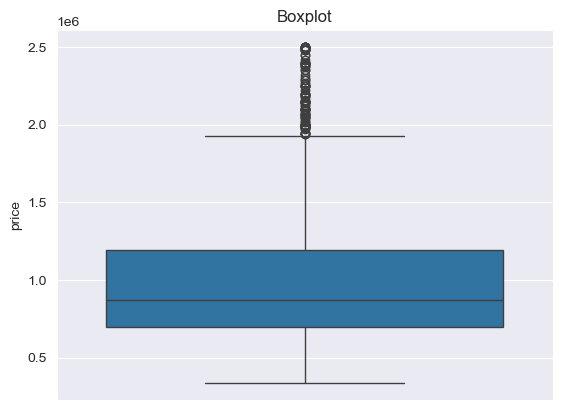

In [7]:
plot_boxplot(Apartment, 'price')

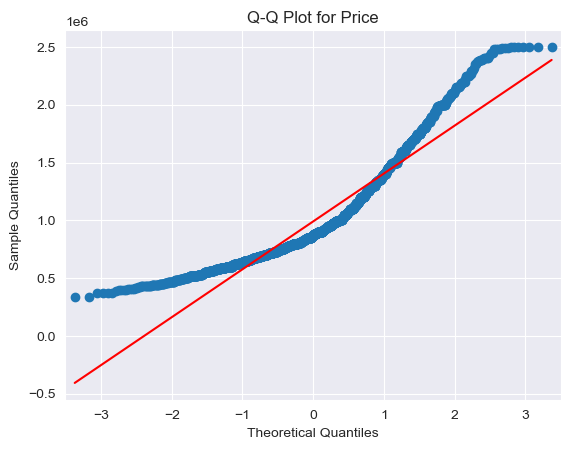

In [8]:
sm.qqplot(Apartment['price'], line='s')
plt.title("Q-Q Plot for Price")
plt.show()

In [9]:
print("Jarque-Bera Test:")
print(jarque_bera(Apartment['price']))

print("\nShapiro-Wilk Test:")
print(shapiro(Apartment['price']))

Jarque-Bera Test:
(979.1481783518628, 2.4025619130737517e-213, 1.2932924582014322, 4.4279295272840855)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.8882190054114916, pvalue=2.0357849374624634e-40)


We performed the sama tests, and we can reject the null hypothesis that the density distribution is normal as in the original research.

 P-values are even smaller than for original dataset, thus confirming that density distribution is not normal.

# Square Meters - reproduction

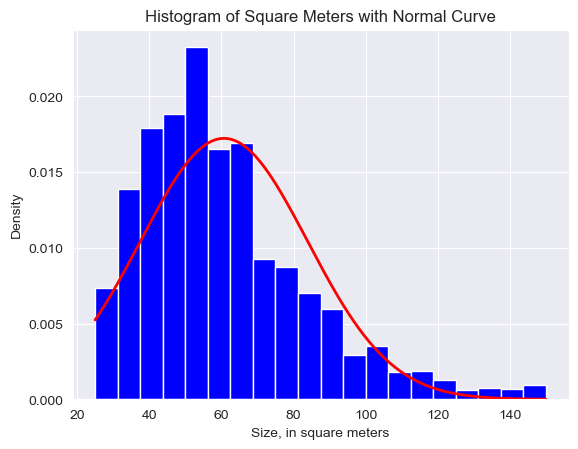

In [10]:
plot_historgram(Apartment, 'squareMeters', 'Size, in square meters', 'Histogram of Square Meters with Normal Curve')

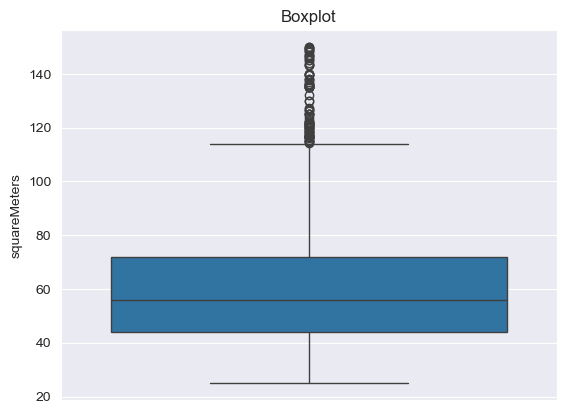

In [11]:
plot_boxplot(Apartment, 'squareMeters')

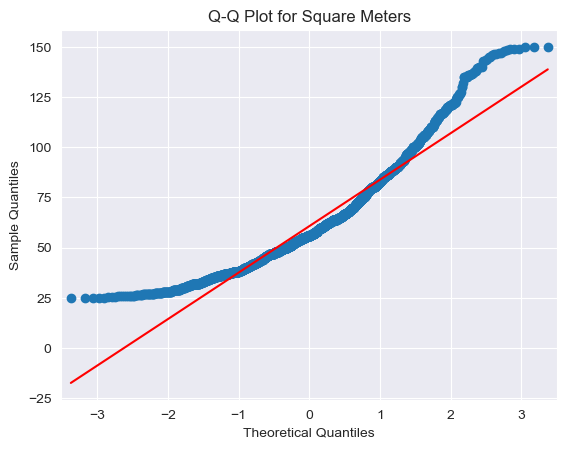

In [12]:
sm.qqplot(Apartment['squareMeters'], line='s')
plt.title("Q-Q Plot for Square Meters")
plt.show()

In [13]:
print("Jarque-Bera Test:")
print(jarque_bera(Apartment['squareMeters']))

print("\nShapiro-Wilk Test:")
print(shapiro(Apartment['squareMeters']))

Jarque-Bera Test:
(784.6573433563725, 4.109819966574456e-171, 1.121494485736472, 4.401591845508675)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9258305926103148, pvalue=1.49516907112125e-34)


As in original research we can reject null hypothesis that density distribution is normal.

# Distance from city centre - reproduction

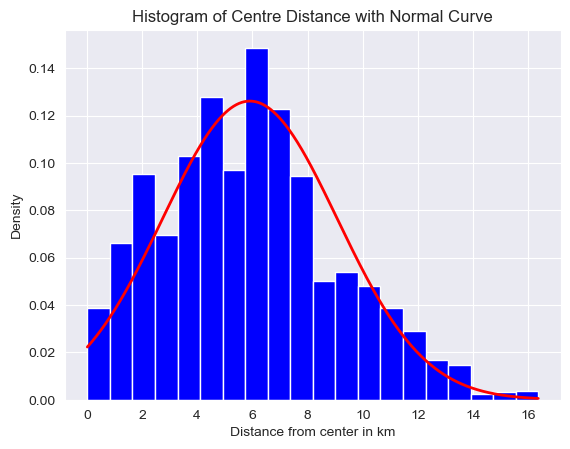

In [14]:
plot_historgram(Apartment, 'centreDistance', 'Distance from center in km',
                'Histogram of Centre Distance with Normal Curve')

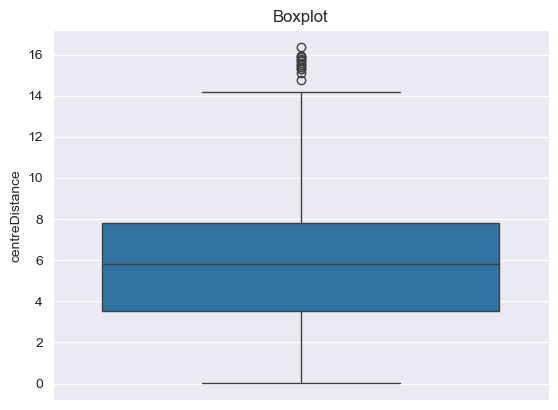

In [15]:
plot_boxplot(Apartment, 'centreDistance')

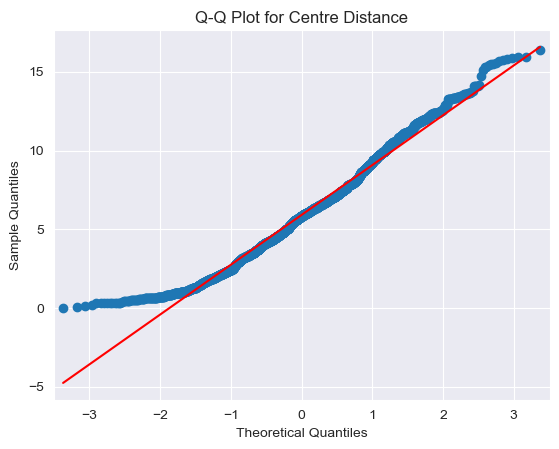

In [16]:
sm.qqplot(Apartment['centreDistance'], line='s')
plt.title("Q-Q Plot for Centre Distance")
plt.show()

In [17]:
print("Jarque-Bera Test:")
print(jarque_bera(Apartment['centreDistance']))

print("\nShapiro-Wilk Test:")
print(shapiro(Apartment['centreDistance']))

Jarque-Bera Test:
(88.99357909081512, 4.734671344806688e-20, 0.4285896975133029, 2.7578257851545436)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9792842972099155, pvalue=2.2474107565810474e-19)


Again as in original research we can reject null hypothesis that density distribution is normal.


Correlation - Price vs squareMeters

In [18]:
# Spearman correlation: price vs squareMeters
print("Spearman Correlation: Price vs Square Meters")
print(spearmanr(Apartment['price'], Apartment['squareMeters']))

# Kendall correlation: price vs centreDistance
print("Kendall Correlation: Price vs Centre Distance")
print(kendalltau(Apartment['price'], Apartment['squareMeters']))

Spearman Correlation: Price vs Square Meters
SignificanceResult(statistic=0.7774666607723111, pvalue=0.0)
Kendall Correlation: Price vs Centre Distance
SignificanceResult(statistic=0.5841106740499615, pvalue=0.0)


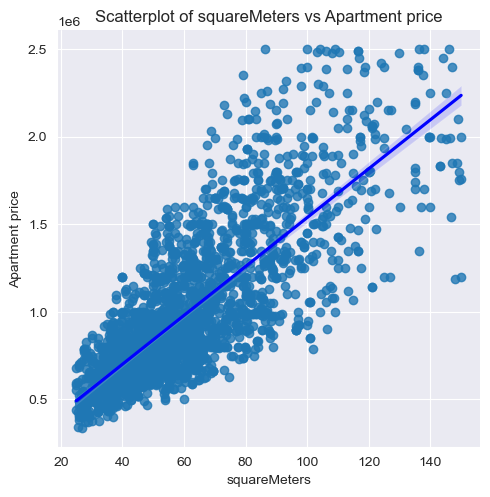

In [19]:
sns.lmplot(x='squareMeters', y='price', data=Apartment, line_kws={"color": "blue"})
plt.title("Scatterplot of squareMeters vs Apartment price")
plt.xlabel("squareMeters")
plt.ylabel("Apartment price")
plt.show()

Correlation - price vs distance from city center

In [20]:
# Spearman correlation: price vs centreDistance
print("\nSpearman Correlation: Price vs Centre Distance")
print(spearmanr(Apartment['price'], Apartment['centreDistance']))

# Kendall correlation: price vs centreDistance
print("Kendall Correlation: Price vs Centre Distance")
print(kendalltau(Apartment['price'], Apartment['centreDistance']))


Spearman Correlation: Price vs Centre Distance
SignificanceResult(statistic=-0.1602719093535959, pvalue=5.965908960665938e-17)
Kendall Correlation: Price vs Centre Distance
SignificanceResult(statistic=-0.10627796282938166, pvalue=1.6338991165323887e-16)


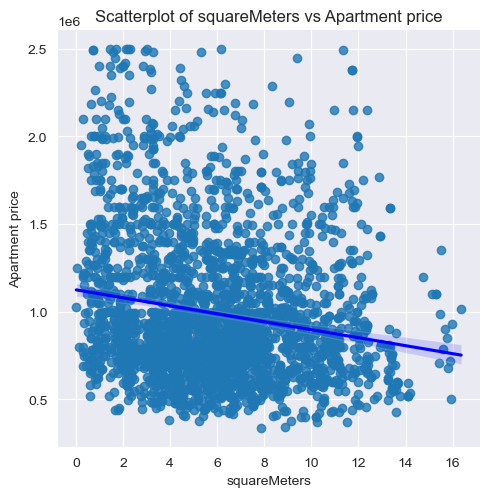

In [21]:
sns.lmplot(x='centreDistance', y='price', data=Apartment, line_kws={"color": "blue"})
plt.title("Scatterplot of squareMeters vs Apartment price")
plt.xlabel("squareMeters")
plt.ylabel("Apartment price")
plt.show()

# Dummy Variables - reproduction

Price Summary by Type:
       count          mean            std       min       25%        50%  \
type                                                                       
1      383.0  1.154426e+06  505288.852497  405000.0  780000.0   998000.0   
2     1522.0  8.527869e+05  303792.239252  335000.0  660000.0   780000.0   
3      787.0  1.177299e+06  447190.990921  340800.0  833390.0  1100000.0   

            75%        max  
type                        
1     1455000.0  2500000.0  
2      950000.0  2500000.0  
3     1455000.0  2500000.0  


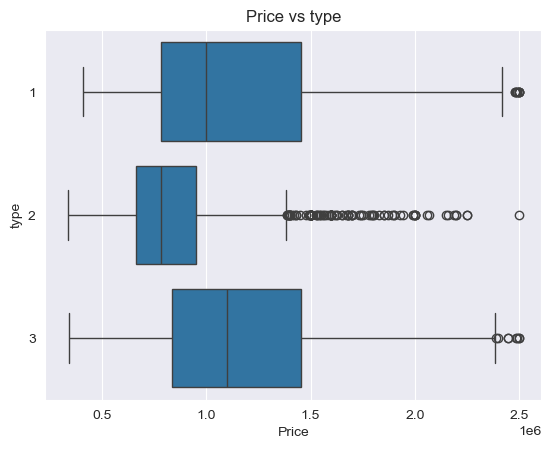

Price Summary by Floortype:
            count          mean            std       min       25%       50%  \
FloorType                                                                      
0           570.0  9.607798e+05  400924.589328  399000.0  683500.0  828000.0   
1           824.0  1.010439e+06  406648.535697  340800.0  723750.0  895888.0   
2          1298.0  9.910435e+05  424135.985312  335000.0  695000.0  881000.0   

                 75%        max  
FloorType                        
0          1164250.0  2500000.0  
1          1220000.0  2500000.0  
2          1169750.0  2500000.0  


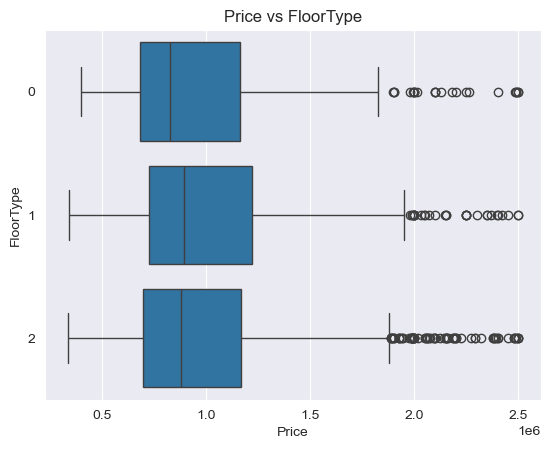

Price Summary by Ownership:
            count          mean            std       min       25%       50%  \
ownership                                                                      
0           381.0  8.519861e+05  339367.994942  375000.0  650000.0  769000.0   
1          2311.0  1.013420e+06  420994.932217  335000.0  710000.0  897000.0   

                 75%        max  
ownership                        
0           927000.0  2380000.0  
1          1220000.0  2500000.0  


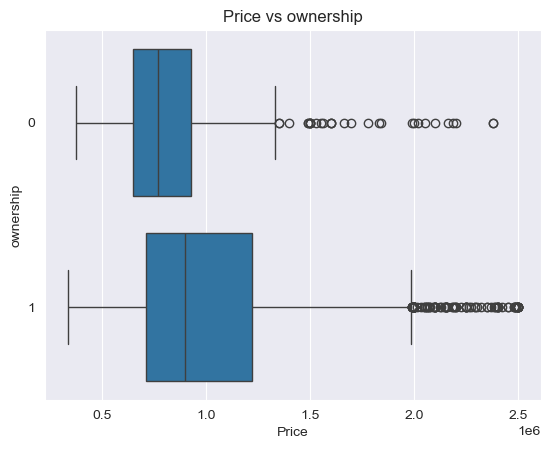

Price Summary by Poicount:
           count          mean            std       min        25%        50%  \
poiCount                                                                        
1         1546.0  9.428063e+05  375502.446049  335000.0  685000.00   845500.0   
2          768.0  9.913683e+05  413059.691303  375000.0  698776.25   867000.0   
3          378.0  1.184316e+06  502715.414851  439000.0  799000.00  1032000.0   

                75%        max  
poiCount                        
1         1100000.0  2499000.0  
2         1220000.0  2500000.0  
3         1488750.0  2500000.0  


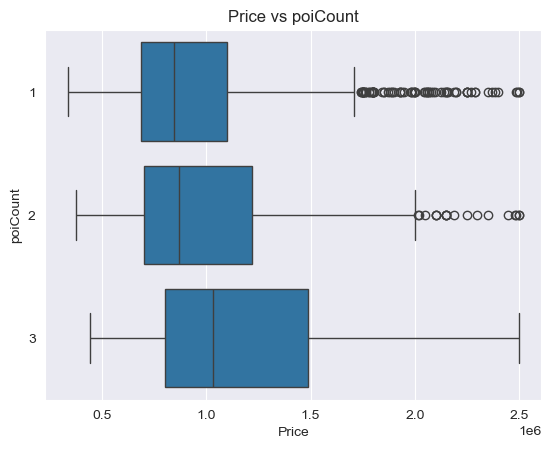

Price Summary by Hasbalcony:
             count          mean            std       min       25%       50%  \
hasBalcony                                                                      
0            861.0  9.422207e+05  401024.166888  335000.0  660000.0  829000.0   
1           1831.0  1.013309e+06  418454.510783  340800.0  720000.0  890000.0   

                  75%        max  
hasBalcony                        
0           1104950.0  2485350.0  
1           1217000.0  2500000.0  


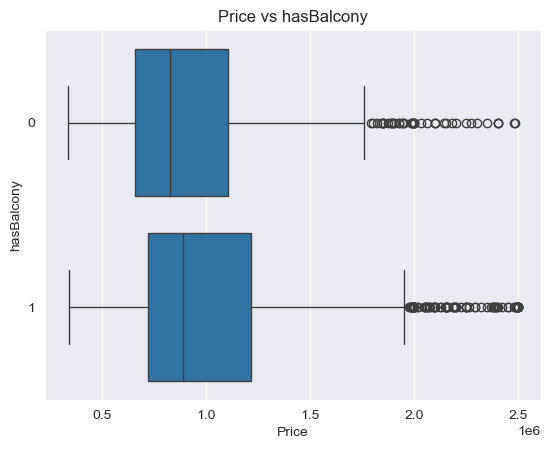

Price Summary by Haselevator:
              count          mean            std       min       25%  \
hasElevator                                                            
0             764.0  9.584553e+05  404734.703656  335000.0  681500.0   
1            1928.0  1.003299e+06  417332.150930  340800.0  708500.0   

                  50%        75%        max  
hasElevator                                  
0            840000.0  1110250.0  2500000.0  
1            890000.0  1200000.0  2500000.0  


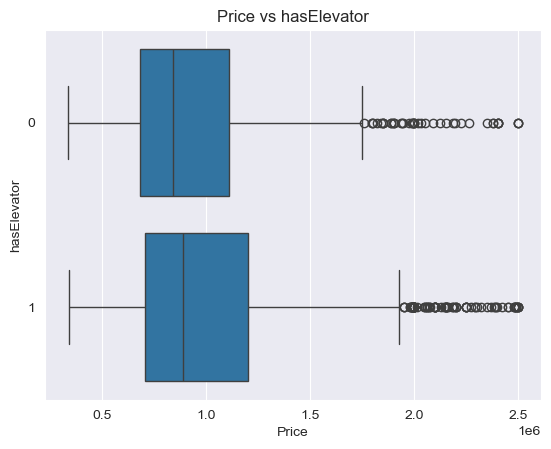

In [25]:
dummy_variables = ['type', 'FloorType', 'ownership', 'poiCount', 'hasBalcony', 'hasElevator']


def table(df: pd.DataFrame):
    for dummy in dummy_variables:
        print(f"Price Summary by {dummy.title()}:")
        print(df.groupby(dummy)['price'].describe())
        sns.boxplot(y=dummy, x='price', data=df, orient='h')
        plt.title(f"Price vs {dummy}")
        plt.xlabel("Price")
        plt.ylabel(dummy)
        plt.show()


table(Apartment)

In [26]:
datacorr = Apartment[["price", "squareMeters", "type", "FloorType",
                      "centreDistance", "poiCount", "ownership",
                      "hasBalcony", "hasElevator"]]

cor_matrix = datacorr.corr(numeric_only=True)
print(cor_matrix)

                   price  squareMeters      type  FloorType  centreDistance  \
price           1.000000      0.779981  0.117646   0.020029       -0.173839   
squareMeters    0.779981      1.000000  0.106610   0.067649        0.131084   
type            0.117646      0.106610  1.000000  -0.092726        0.263294   
FloorType       0.020029      0.067649 -0.092726   1.000000        0.044807   
centreDistance -0.173839      0.131084  0.263294   0.044807        1.000000   
poiCount        0.181826     -0.026246 -0.274118   0.005110       -0.542058   
ownership       0.135874      0.012662  0.086622  -0.008069        0.003341   
hasBalcony      0.080062      0.130568  0.170236  -0.030486        0.168919   
hasElevator     0.048818     -0.085928  0.392313  -0.193875       -0.012881   

                poiCount  ownership  hasBalcony  hasElevator  
price           0.181826   0.135874    0.080062     0.048818  
squareMeters   -0.026246   0.012662    0.130568    -0.085928  
type           -0.27

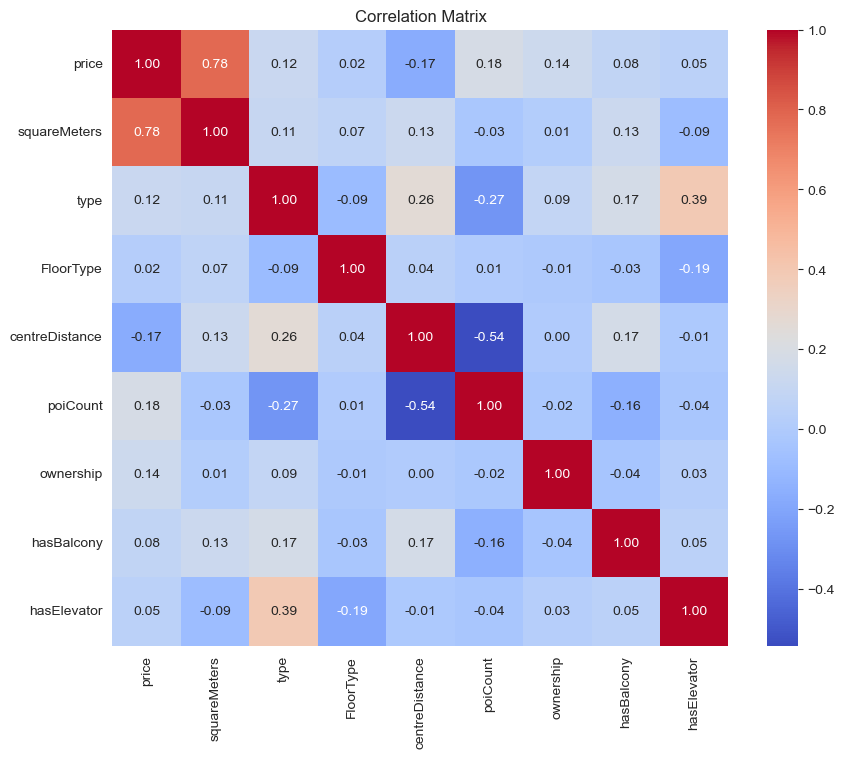

Significant Correlations with 'price' (p < 0.05):
       X               Y         r         p-unc
0  price    squareMeters  0.779981  0.000000e+00
4  price        poiCount  0.181826  1.926525e-21
3  price  centreDistance -0.173839  1.040788e-19
5  price       ownership  0.135874  1.448255e-12
1  price            type  0.117646  9.214302e-10
6  price      hasBalcony  0.080062  3.200572e-05
7  price     hasElevator  0.048818  1.130087e-02


In [27]:
# Correlation matrix with values
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

# With significance levels (p-values)
results = pg.pairwise_corr(datacorr, method='pearson')
sig_corrs = results[results['p-unc'] < 0.05]

# Filter to only rows where 'price' is one of the variables
price_corrs = sig_corrs[(sig_corrs['X'] == 'price') | (sig_corrs['Y'] == 'price')]

# Optional: sort by absolute correlation strength
price_corrs = price_corrs.copy()
price_corrs['abs_r'] = price_corrs['r'].abs()
price_corrs = price_corrs.sort_values('abs_r', ascending=False)

# Display cleaned result
print("Significant Correlations with 'price' (p < 0.05):")
print(price_corrs[['X', 'Y', 'r', 'p-unc']])

## REGRESSION

In [3]:
# Step 1: Ensure correct data types (convert to integers)
cols_to_int = ['type', 'FloorType', 'ownership', 'hasBalcony', 'hasElevator', 'poiCount']
Apartment[cols_to_int] = Apartment[cols_to_int].apply(pd.to_numeric, errors='coerce').astype('Int64')

# Step 2: Convert to categorical and rename categories (use existing values directly)
Apartment['type'] = Apartment['type'].astype('category')
Apartment['type'] = Apartment['type'].cat.rename_categories({1: 'tenement', 2: 'blockOfFlats', 3: 'apartmentBuilding'})

Apartment['FloorType'] = Apartment['FloorType'].astype('category')
Apartment['FloorType'] = Apartment['FloorType'].cat.rename_categories({0: 'low', 1: 'middle', 2: 'high'})

Apartment['ownership'] = Apartment['ownership'].astype('category')
Apartment['ownership'] = Apartment['ownership'].cat.rename_categories({0: 'cooperative', 1: 'condominium'})

Apartment['hasBalcony'] = Apartment['hasBalcony'].astype('category')
Apartment['hasBalcony'] = Apartment['hasBalcony'].cat.rename_categories({0: 'no', 1: 'yes'})

Apartment['hasElevator'] = Apartment['hasElevator'].astype('category')
Apartment['hasElevator'] = Apartment['hasElevator'].cat.rename_categories({0: 'no', 1: 'yes'})

Apartment['poiCount'] = Apartment['poiCount'].astype('category')
Apartment['poiCount'] = Apartment['poiCount'].cat.rename_categories({1: 'small', 2: 'medium', 3: 'large'})

print(Apartment.dtypes)
print(Apartment.head())


type              category
squareMeters       float64
FloorType         category
centreDistance     float64
poiCount          category
ownership         category
hasBalcony        category
hasElevator       category
price                int64
dtype: object
                type  squareMeters FloorType  centreDistance poiCount  \
0       blockOfFlats         62.20      high           10.31    small   
1       blockOfFlats         73.40    middle            5.68    large   
2           tenement         50.33    middle            2.41   medium   
3  apartmentBuilding         34.00       low           10.14    small   
4       blockOfFlats         48.07      high            0.67    large   

     ownership hasBalcony hasElevator   price  
0  condominium        yes          no  680000  
1  condominium        yes         yes  954000  
2  condominium        yes          no  880000  
3  condominium        yes         yes  650000  
4  cooperative         no         yes  720000  


In [6]:
print(Apartment.dtypes)
print(Apartment['type'].value_counts())

type              category
squareMeters       float64
FloorType         category
centreDistance     float64
poiCount          category
ownership         category
hasBalcony        category
hasElevator       category
price                int64
dtype: object
type
blockOfFlats         1522
apartmentBuilding     787
tenement              383
Name: count, dtype: int64


In [7]:
print(Apartment['FloorType'].value_counts())

FloorType
high      1298
middle     824
low        570
Name: count, dtype: int64


In [8]:
print(Apartment['poiCount'].value_counts())

poiCount
small     1546
medium     768
large      378
Name: count, dtype: int64


In [9]:
print(Apartment['ownership'].value_counts())

ownership
condominium    2311
cooperative     381
Name: count, dtype: int64


In [10]:
print(Apartment['hasBalcony'].value_counts())

hasBalcony
yes    1831
no      861
Name: count, dtype: int64


In [11]:
print(Apartment['hasElevator'].value_counts())

hasElevator
yes    1928
no      764
Name: count, dtype: int64


In [12]:
print(Apartment.isnull().sum())          # 检查缺失值
print(Apartment.dtypes)                  # 检查变量类型
print(Apartment.shape)                   # 查看行列数
print(Apartment.head())                  # 看前几行是否数据正常


type              0
squareMeters      0
FloorType         0
centreDistance    0
poiCount          0
ownership         0
hasBalcony        0
hasElevator       0
price             0
dtype: int64
type              category
squareMeters       float64
FloorType         category
centreDistance     float64
poiCount          category
ownership         category
hasBalcony        category
hasElevator       category
price                int64
dtype: object
(2692, 9)
                type  squareMeters FloorType  centreDistance poiCount  \
0       blockOfFlats         62.20      high           10.31    small   
1       blockOfFlats         73.40    middle            5.68    large   
2           tenement         50.33    middle            2.41   medium   
3  apartmentBuilding         34.00       low           10.14    small   
4       blockOfFlats         48.07      high            0.67    large   

     ownership hasBalcony hasElevator   price  
0  condominium        yes          no  680000  
1  co

In [13]:
# Initial linear regression model (equivalent to regression1)
regression1 = smf.ols('price ~ type + squareMeters + FloorType + centreDistance + poiCount + ownership + hasBalcony + hasElevator', data=Apartment).fit()
print(regression1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     757.3
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        21:39:21   Log-Likelihood:                -36736.
No. Observations:                2692   AIC:                         7.350e+04
Df Residuals:                    2680   BIC:                         7.357e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

* In the results of this first regression model, we find that the results are the same as those obtained by the original author in R, only the form is a bit different.
* Given significance level of 1%, non- significant variables are: type_apartment building, Floor type middle and floor type high, but as F-statistic shows all variables result in joint significance. R-squared is 0.757 and Adjusted R-squared is 0.756.

* In R, the power is 2:3, here we need to be aware that we should use the highest power 3 to get the same result like in R

In [22]:
# RESET test (fitted)
reset_fitted = linear_reset(regression1, power=3, use_f=True)
print("\nRESET test (fitted):", reset_fitted)

# RESET test (regressor)
reset_regressor = linear_reset(regression1, power=3, use_f=True)
print("\nRESET test (regressor):", reset_regressor)


RESET test (fitted): <F test: F=28021.699707244898, p=0.0, df_denom=2.69e+03, df_num=2>

RESET test (regressor): <F test: F=28021.699707244898, p=0.0, df_denom=2.69e+03, df_num=2>


* Here we get the same result as in the original paper， the first model rejects the assumption of linearity

* in regression2, we log-transformed the price and changed the forms of some of the independent variables as the author did. (Interaction terms and taking polynomials)

In [15]:
# Fitting a nonlinear model regression2
Apartment['log_price'] = np.log(Apartment['price'])
Apartment['squareMeters_2'] = Apartment['squareMeters']**2
Apartment['centreDistance_2'] = Apartment['centreDistance']**2
Apartment['centreDistance_3'] = Apartment['centreDistance']**3

formula2 = 'log_price ~ poly(squareMeters, 2, raw=True) + poly(centreDistance, 3, raw=True) + type + type:squareMeters + hasBalcony + poiCount + hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance'
regression2 = smf.ols('log_price ~ squareMeters + I(squareMeters ** 2) + centreDistance + I(centreDistance ** 2) + I(centreDistance ** 3) + type + type:squareMeters + hasBalcony + poiCount + hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance', data=Apartment).fit()
print(regression2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     615.5
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        22:03:20   Log-Likelihood:                 921.08
No. Observations:                2692   AIC:                            -1806.
Df Residuals:                    2674   BIC:                            -1700.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

* Here we almost get the same result as the author did. Only difference is that in the paper using R, there didn't show the coefficents for squareMeters and centreDistance, author thought this is because I use the polynomials to the both variables and 
the interactions. However, using Python, we saw the coefficients for them, and both of them are significant.

This difference is actually a difference between R and Python (statsmodels) in the way they handle multicollinearity and output regression results, especially with polynomial terms and interaction terms. If R finds that some variables are perfectly linearly correlated with other variables (i.e., the covariates are highly covariant), R automatically “discards” these variables and does not show their coefficients in the regression results (called the “aliased” parameter). The variables are considered redundant. In Python (statsmodels) the coefficients of all variables are displayed.

In [20]:
# RESET 
print("\nRESET test (fitted):", linear_reset(regression2, power=3, use_f=True))
print("\nRESET test (regressor):", linear_reset(regression2, power=3, use_f=True))


RESET test (fitted): <F test: F=17.26049188724906, p=3.5634759050884294e-08, df_denom=2.67e+03, df_num=2>

RESET test (regressor): <F test: F=17.26049188724906, p=3.5634759050884294e-08, df_denom=2.67e+03, df_num=2>


* In R, fit and regressor get different detection values, but in Python they are the same. This is because R and Python add variables differently, and there may be a simplifying logic within the Python implementation where the expansion of fitted and regressor coincide when the model contains polynomials and interaction terms, causing the two tests to “look” the same. (The more complex the model, the more likely this phenomenon is to occur)

## DIAGNOSTIC TEST 

### Linearity

In [26]:
Apartment['squareMeters2'] = Apartment['squareMeters'] ** 2
Apartment['squareMeters3'] = Apartment['squareMeters'] ** 3
Apartment['centreDistance2'] = Apartment['centreDistance'] ** 2
Apartment['centreDistance3'] = Apartment['centreDistance'] ** 3

reset_model = smf.ols(
    'log_price ~ squareMeters + squareMeters2 + squareMeters3 + '
    'centreDistance + centreDistance2 + centreDistance3 + '
    'type + type:squareMeters + hasBalcony + poiCount + '
    'hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance',
    data=Apartment
).fit()

from statsmodels.stats.anova import anova_lm
anova_result = anova_lm(regression2, reset_model)
print(anova_result)


   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0    2674.0  79.507647      0.0       NaN       NaN       NaN
1    2673.0  79.507371      1.0  0.000277  0.009304  0.923163


* The added variables (e.g., non-linear terms) do not significantly increase the explanatory power of the model, so it can be assumed that the model has no serious omitted variable bias (i.e., there are no serious violations of the linearity assumption) - at least from the point of view of the RESET test.

This is consistent with what the author got with type = “regressor” in R (the p-value is 0.016, greater than 0.01)

### Normality of residuals

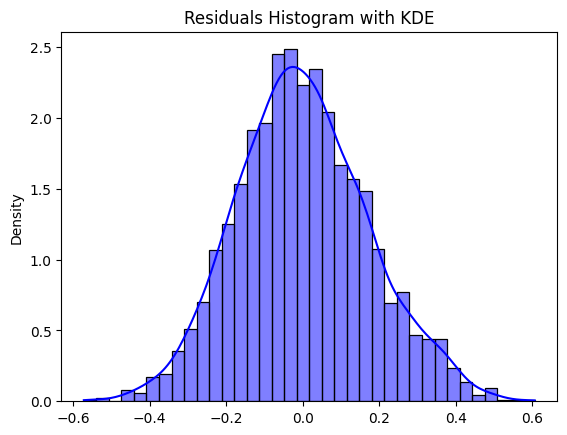

In [30]:
residuals = regression2.resid
sns.histplot(residuals, kde=True, color='blue', stat="density")
plt.title("Residuals Histogram with KDE")
plt.show()

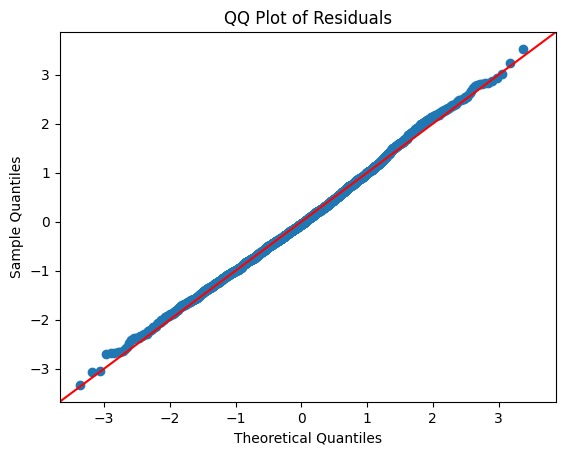

In [28]:
# QQ plot of residuals
sm.qqplot(regression2.resid, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

In [31]:
# Jarque-Bera test
jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
print("\nJarque-Bera test: statistic = %.4f, p-value = %.4f" % (jb_stat, jb_pvalue))



Jarque-Bera test: statistic = 14.4196, p-value = 0.0007


* We got the same plots and test results as the author did, the assumption of normality is rejected. However, author didn't conduct further modifications for the fact that from the test the distribution of residuals is not normal because of the law of large numbers. 

### Homoscedasticity

In [32]:
# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, regression2.model.exog)
print("\nBreusch-Pagan test:", lzip(['LM stat', 'LM p-value', 'F stat', 'F p-value'], bp_test))


Breusch-Pagan test: [('LM stat', np.float64(104.38398254989903)), ('LM p-value', np.float64(1.3613379911312856e-14)), ('F stat', np.float64(6.345217497861999)), ('F p-value', np.float64(6.661495175609001e-15))]


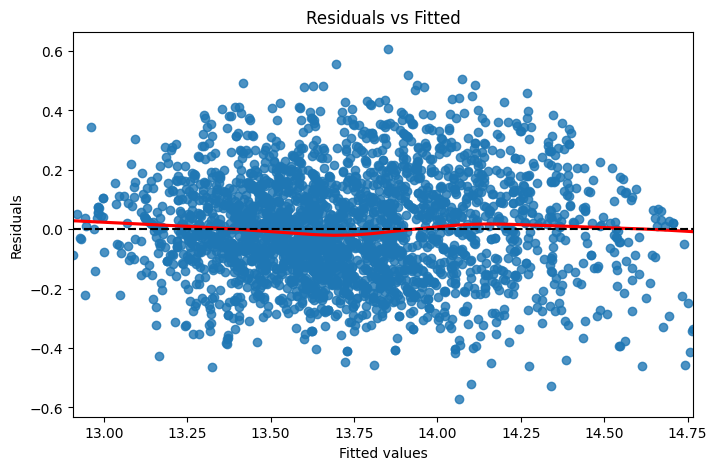

In [33]:
fitted_vals = regression2.fittedvalues
residuals = regression2.resid

plt.figure(figsize=(8, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(0, color='black', linestyle='--')
plt.show()

* As for homoscedasticity, we got the same results and plot. This assumption is confirmed by Breusch-Pagan test, in which we reject the H0 
that the regression is homoscedastic.

* To solve this problem we applied a robust variance-covariance matrix to the 
regression as the author did. 

In [36]:
from statsmodels.stats.sandwich_covariance import cov_hc0, cov_hc3
from statsmodels.stats.contrast import ContrastResults
from statsmodels.iolib.summary2 import summary_col
robust_HC0 = regression2.get_robustcov_results(cov_type='HC0')
robust_HC3 = regression2.get_robustcov_results(cov_type='HC3')

print(summary_col([regression2, robust_HC0, robust_HC3], stars=True, model_names=['OLS', 'HC0', 'HC3']))


                                           OLS        HC0        HC3    
------------------------------------------------------------------------
Intercept                               12.5488*** 12.5488*** 12.5488***
                                        (0.0474)   (0.0478)   (0.0484)  
type[T.blockOfFlats]                    -0.0270    -0.0270    -0.0270   
                                        (0.0289)   (0.0273)   (0.0277)  
type[T.apartmentBuilding]               0.1136***  0.1136***  0.1136*** 
                                        (0.0310)   (0.0300)   (0.0304)  
hasBalcony[T.yes]                       0.0268***  0.0268***  0.0268*** 
                                        (0.0075)   (0.0072)   (0.0072)  
poiCount[T.medium]                      0.0336**   0.0336**   0.0336**  
                                        (0.0149)   (0.0146)   (0.0147)  
poiCount[T.large]                       0.1223***  0.1223***  0.1223*** 
                                        (0.0209)  

* Here we got almost the same results as in the paper.

### Multicollinearity

In [17]:
# VIF test
X = regression2.model.exog
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = regression2.model.exog_names
print("\nVIF Table:\n", vif)


VIF Table:
     VIF Factor                                 features
0   203.293204                                Intercept
1    18.537893                     type[T.blockOfFlats]
2    18.052453                type[T.apartmentBuilding]
3     1.095577                        hasBalcony[T.yes]
4     4.077735                       poiCount[T.medium]
5     4.767687                        poiCount[T.large]
6     1.984010                       hasElevator[T.yes]
7     6.052996                 ownership[T.condominium]
8     4.203836    hasElevator[T.yes]:poiCount[T.medium]
9     4.009285     hasElevator[T.yes]:poiCount[T.large]
10   28.374731                             squareMeters
11   18.593022        type[T.blockOfFlats]:squareMeters
12   19.839708   type[T.apartmentBuilding]:squareMeters
13   21.524891                     I(squareMeters ** 2)
14  123.251708                           centreDistance
15   15.677083  ownership[T.condominium]:centreDistance
16  447.064234                   I(

* Here we got the same results as in the paper. VIF should be smaller than 10, but we follow the author, remain the model unchanged. As the author explained that many of the variables that we will have to omit because of this are significant and are important for the RESET test.
